In [1]:
import os
import sys

code_directory = os.path.join(os.path.dirname(os.getcwd()), 'code')
sys.path.insert(0, code_directory)

## Tutorial jupyter notebook

#### Specify the simulation inputs

In [2]:
from Simulation import Simulation

# Create simulation object
simulation = Simulation('tutorial.yaml')

simulation.domain_properties

{'molecule': 'born_ion',
 'epsilon_1': 1,
 'epsilon_2': 80,
 'kappa': 0.125,
 'T': 300}

#### Create the simulation

In [3]:
simulation.create_simulation()
simulation.adapt_simulation()

Mesh initialization ready
PDEs and datasets ready


#### Solve the model

In [4]:
simulation.solve_model()

Loss: 8.1365e+03: 100%|██████████| 150/150 [00:44<00:00,  3.37it/s]


#### Postprocessing object

In [5]:
Post = simulation.postprocessing(jupyter=True)

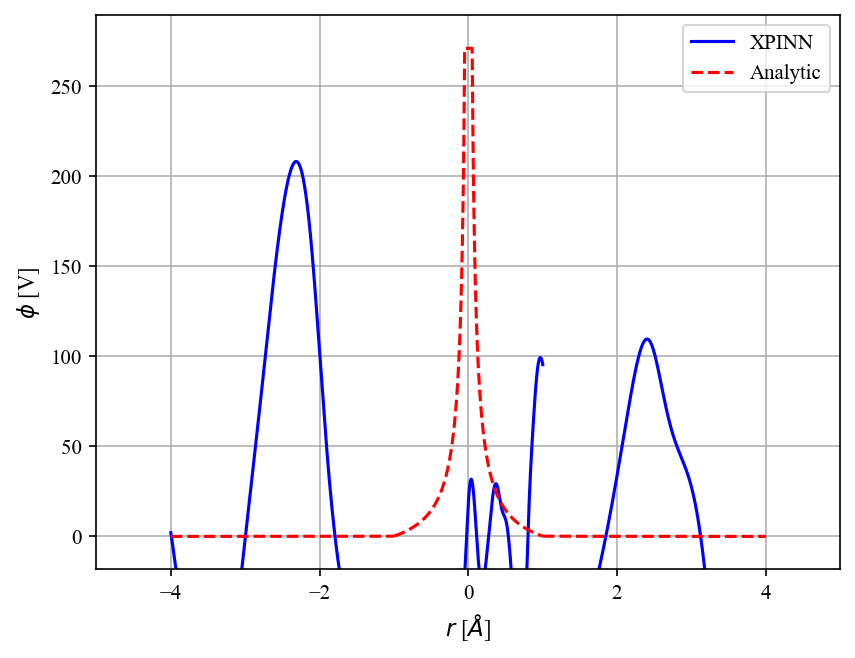

In [6]:
Post.plot_aprox_analytic();